<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/langchain/langgraph/LangGraph_research_automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Assistant

## Topics

* Memory
* Human-in-the-loop
* Controllability

### research automation.

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows.

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection`
* Users can choose any set of input sources for their research.
  
`Planning`
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state.
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format`
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format.

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia langchain-google-genai google-cloud-aiplatform

In [2]:
!pip install semanticscholar -q

## Setup

In [3]:
import os, getpass
from google.colab import userdata
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

#_set_env("OPENAI_API_KEY")

In [4]:
if "GEMINI_API_KEY" not in os.environ:
    os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = userdata.get('KEY_OPENAI')

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

In [7]:
#llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-002")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [8]:
#_set_env("LANGCHAIN_API_KEY")
if "LANGCHAIN_API_KEY" not in os.environ:
    os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-research"

## Generate Analysts: Human-In-The-Loop

A single shared state makes the process easier to observe, interrupt and modify. Which is very important for complex LLM applications, where some amount of human supervision/approval/editing can be the difference between a toy and a deployment useful in the real world

Create analysts and review them using human-in-the-loop.

https://blog.langchain.dev/human-in-the-loop-with-opengpts-and-langgraph/



In [9]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

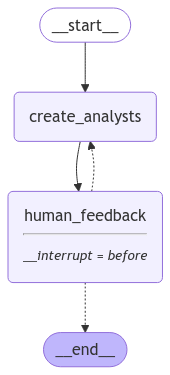

In [44]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):

    """ Create analysts """

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    # Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END

# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [45]:
# Input
max_analysts = 3
topic = "The benefits of adopting a healthy life style to prevent cardiovascular conditions"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: American Heart Association
Role: Cardiologist
Description: Dr. Carter focuses on the direct impact of lifestyle changes on cardiovascular health. She is particularly interested in how diet, exercise, and stress management can reduce the risk of heart disease. Her motive is to provide evidence-based recommendations to patients and healthcare providers to promote heart health.
--------------------------------------------------
Name: Prof. Michael Nguyen
Affiliation: Harvard T.H. Chan School of Public Health
Role: Public Health Researcher
Description: Prof. Nguyen examines the broader public health implications of adopting a healthy lifestyle. He is concerned with how lifestyle interventions can be implemented at a community level to prevent cardiovascular conditions. His research aims to influence policy and create sustainable health programs.
--------------------------------------------------
Name: Sarah Thompson
Affiliation: Wellness and Nutrition In

In [46]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [47]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                            "Add in someone with a Pharmateuthical Research background"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd7b9a-7ef1-6ff6-8002-6c419a8aa363'}}

In [48]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: American Heart Association
Role: Cardiologist
Description: Dr. Carter focuses on the direct impact of lifestyle changes on cardiovascular health. She is particularly interested in how diet, exercise, and stress management can reduce the risk of heart disease. Her motive is to provide evidence-based recommendations to patients and healthcare providers to promote heart health.
--------------------------------------------------
Name: Prof. Michael Nguyen
Affiliation: Harvard T.H. Chan School of Public Health
Role: Public Health Researcher
Description: Prof. Nguyen examines the broader public health implications of adopting a healthy lifestyle. He is concerned with how lifestyle interventions can be implemented at a community level to prevent cardiovascular conditions. His research aims to influence policy and create sustainable health programs.
--------------------------------------------------
Name: Sarah Thompson
Affiliation: Wellness and Nutrition In

In [49]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback":
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd7b9c-1f4f-6cc5-8004-a612bf0b9528'}}

In [50]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [51]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [18]:
final_state.next

()

In [52]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Dr. Emily Carter
Affiliation: American Heart Association
Role: Cardiologist
Description: Dr. Carter focuses on the clinical benefits of a healthy lifestyle in preventing cardiovascular diseases. She is particularly interested in how diet, exercise, and stress management can reduce the risk of heart attacks and strokes. Her motive is to promote evidence-based lifestyle changes that can be adopted by the general population to improve heart health.
--------------------------------------------------
Name: Dr. Raj Patel
Affiliation: National Institute of Health
Role: Public Health Researcher
Description: Dr. Patel examines the broader public health implications of adopting a healthy lifestyle. He is concerned with how lifestyle changes can be implemented at a community level to reduce the prevalence of cardiovascular conditions. His research includes studying the impact of public health campaigns and policies that encourage healthy living.
---------------------------------------------

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [20]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [21]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [22]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(f"{var}")

os.environ["TAVILY_API_KEY"]=  userdata.get("TAVILY_API_KEY")

In [23]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [24]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

In [25]:
# Semantic Scholar search tool
from langchain_community.utilities.semanticscholar import SemanticScholarAPIWrapper
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["GOOGLE_CSE_ID"] = userdata.get("GOOGLE_CSE_ID")
os.environ["USER_AGENT"] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'
google_scholar = SemanticScholarAPIWrapper(
                    doc_content_chars_max=10000, top_k_results=10
                )

In [26]:

from langchain_community.tools.semanticscholar.tool import SemanticScholarQueryRun
from langchain_community.utilities.semanticscholar import SemanticScholarAPIWrapper
from langchain.agents import AgentExecutor, create_openai_functions_agent, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate

api_wrapper = SemanticScholarAPIWrapper(doc_content_chars_max=5000, top_k_results=10)
tools = [SemanticScholarQueryRun(api_wrapper=api_wrapper)]




In [27]:
prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

              Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

              First, analyze the full conversation.

              Pay particular attention to the final question posed by the analyst.

              Convert this final question into a well-structured web search query"""),

        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

In [28]:
agent = create_tool_calling_agent(llm, tools, prompt)

In [66]:
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,
)

In [67]:
response = agent_executor.invoke(
    {
        "input": topic
    }
)

In [68]:
response['output']

'Benefits of adopting a healthy lifestyle for preventing cardiovascular conditions'

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

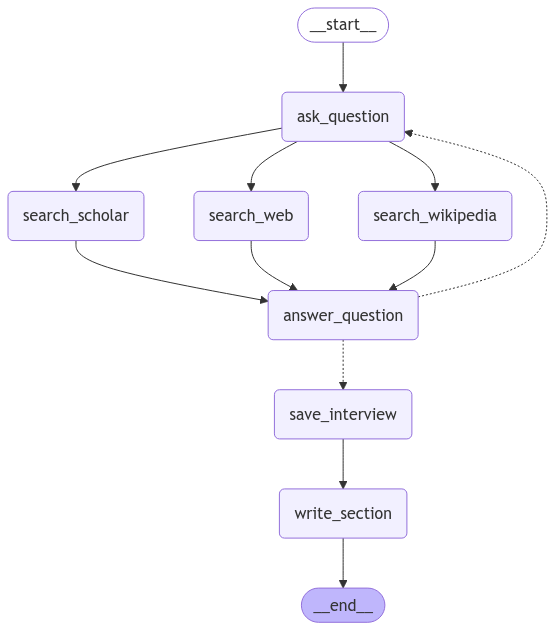

In [69]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):

    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def search_scholar(state: InterviewState):

    """ Retrieve docs from scholar """

    response = agent_executor.invoke( {
        "input": topic
    }

)

    return {"context": [response['output']]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):

    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("search_scholar", search_scholar)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("ask_question", "search_scholar")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_edge("search_scholar", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [70]:
# Pick one analyst
analysts[1]

Analyst(affiliation='Harvard T.H. Chan School of Public Health', name='Prof. Michael Nguyen', role='Public Health Researcher', description='Prof. Nguyen studies the broader public health implications of lifestyle changes. He is concerned with how societal factors such as access to healthy foods and safe exercise environments influence cardiovascular health outcomes. His research aims to inform policy changes that support healthier communities.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [71]:
topic

'The benefits of adopting a healthy life style to prevent cardiovascular conditions'

In [72]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 3}, thread)
Markdown(interview['sections'][0])

## The Power of Lifestyle Changes in Preventing Cardiovascular Diseases

### Summary

Cardiovascular diseases (CVDs) remain a leading cause of mortality worldwide, but the good news is that many of these conditions are preventable through lifestyle modifications. Dr. Carter's focus on the direct impact of lifestyle changes on heart health is particularly relevant in today's context, where sedentary lifestyles and poor dietary habits are prevalent. The insights gathered from recent studies and articles highlight the significant role that diet and exercise play in reducing the risk of CVDs, offering novel and practical preventive measures that can be easily adopted by the general population.

1. **Dietary Adjustments**: A heart-healthy diet is crucial in preventing cardiovascular diseases. Emphasizing the consumption of plant-based foods, high in fiber and omega-3 fatty acids, while reducing the intake of saturated fats and sugars, can significantly lower the risk of heart disease. Diets such as the Mediterranean and DASH diets are particularly recommended for their heart-protective benefits [1][2].

2. **Regular Exercise**: Physical activity is a cornerstone of heart health. Engaging in at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous activity per week is advised to maintain cardiovascular fitness. Exercise not only helps in managing body weight but also improves blood pressure and cholesterol levels, reducing the risk of heart attacks and strokes [3][4].

3. **Sedentary Lifestyle Risks**: A sedentary lifestyle is a significant risk factor for cardiovascular diseases. Prolonged sitting and lack of physical activity contribute to obesity and other health issues that increase the risk of heart disease. Reducing screen time and incorporating more physical movement into daily routines are essential steps in mitigating these risks [5].

4. **Preventive Healthcare**: Regular medical checkups and screenings are vital components of preventive healthcare. Identifying risk factors early and managing them through lifestyle changes and, if necessary, medication, can prevent the progression of heart disease. Preventive measures are not only cost-effective but also crucial in reducing the burden of non-communicable diseases globally [6].

5. **Mental Health and Stress Management**: Mental health is increasingly recognized as a factor in heart health. Chronic stress and poor mental health can negatively impact cardiovascular health. Incorporating stress-reducing activities such as mindfulness, yoga, or meditation can complement other lifestyle changes to enhance heart health [2].

These insights underscore the importance of adopting a holistic approach to heart health, where diet, exercise, and mental well-being are integrated into daily life. By making these lifestyle changes, individuals can significantly reduce their risk of cardiovascular diseases and improve their overall quality of life.

### Sources
[1] https://www.verywellhealth.com/how-to-improve-heart-health-8733586  
[2] https://www.health.harvard.edu/blog/lifestyle-changes-to-lower-heart-disease-risk-2019110218125  
[3] https://www.healthline.com/health/healthy-heart-tips  
[4] https://www.heart.org/en/healthy-living/fitness/getting-active/breaking-down-barriers-to-fitness  
[5] https://en.wikipedia.org/wiki/Sedentary_lifestyle  
[6] https://en.wikipedia.org/wiki/Preventive_healthcare  

### Parallelze interviews: Map-Reduce
Map-reduce operations are essential for efficient task decomposition and parallel processing. This approach involves breaking a task into smaller sub-tasks, processing each sub-task in parallel, and aggregating the results across all of the completed sub-tasks.


https://langchain-ai.github.io/langgraph/how-tos/map-reduce/



We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.
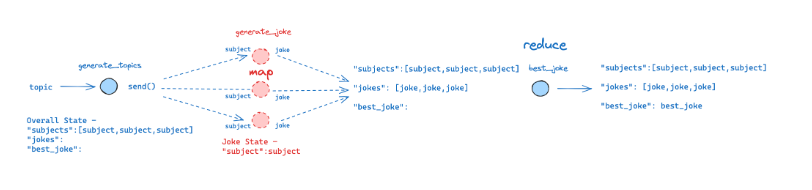
### Finalize

We add a final step to write an intro and conclusion to the final report.

In [73]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

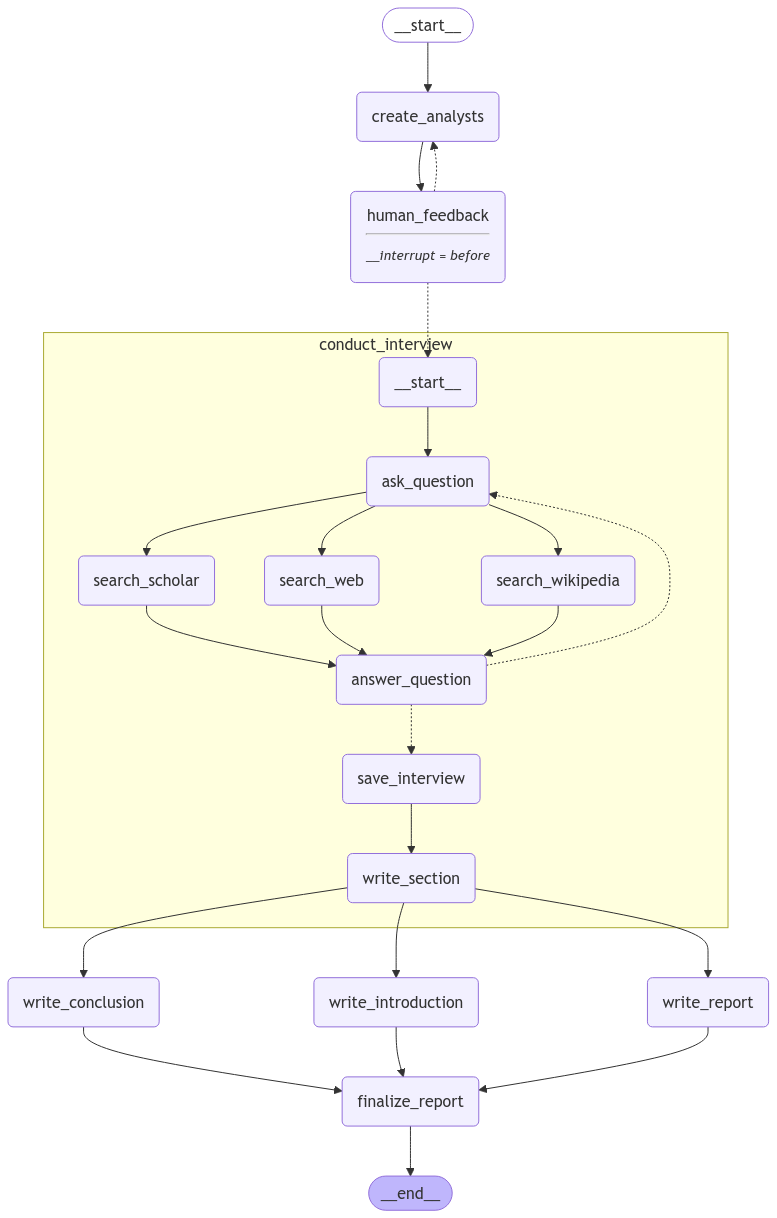

In [74]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [75]:
# Inputs
max_analysts = 5
topic = "The benefits of adopting a healthy life style to prevent cardiovascular conditions"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Chen
Affiliation: Harvard School of Public Health
Role: Epidemiologist
Description: Dr. Chen focuses on the population-level impacts of lifestyle changes on cardiovascular health. She is particularly interested in how diet and exercise can reduce the incidence of heart disease across different demographics.
--------------------------------------------------
Name: Dr. Michael Thompson
Affiliation: American Heart Association
Role: Cardiologist
Description: Dr. Thompson is a cardiologist who advocates for preventive measures in cardiovascular health. His work emphasizes the importance of early lifestyle interventions to reduce the risk of heart disease.
--------------------------------------------------
Name: Dr. Aisha Patel
Affiliation: World Health Organization
Role: Public Health Advocate
Description: Dr. Patel is dedicated to promoting global health initiatives that encourage healthy living. She focuses on policy development and community programs that support cardiova

In [76]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                                "Add somebody with Pharmaceutical reasearch Background   "}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd7bcd-4488-619c-8002-4d3644eb222d'}}

In [77]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Chen
Affiliation: Harvard School of Public Health
Role: Epidemiologist
Description: Dr. Chen focuses on the population-level impacts of lifestyle changes on cardiovascular health. She is particularly interested in how diet and exercise can reduce the incidence of heart disease across different demographics.
--------------------------------------------------
Name: Dr. Michael Thompson
Affiliation: American Heart Association
Role: Cardiologist
Description: Dr. Thompson is a cardiologist who advocates for preventive measures in cardiovascular health. His work emphasizes the importance of early lifestyle interventions to reduce the risk of heart disease.
--------------------------------------------------
Name: Dr. Aisha Patel
Affiliation: World Health Organization
Role: Public Health Advocate
Description: Dr. Patel is dedicated to promoting global health initiatives that encourage healthy living. She focuses on policy development and community programs that support cardiova

In [78]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd7bce-10f1-6a14-8004-ac7a75a69472'}}

In [79]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [80]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Embracing a Healthy Lifestyle: A Pathway to Cardiovascular Wellness

## Introduction

Cardiovascular disease (CVD) remains a leading cause of mortality, yet up to 90% of cases are preventable through lifestyle changes. This report explores the transformative potential of adopting a healthy lifestyle to mitigate CVD risk. We delve into the synergistic effects of diet, exercise, and stress management, highlighting evidence from landmark studies. Community-level strategies and the integration of pharmaceuticals with lifestyle changes further underscore the importance of a holistic approach. Additionally, the Mediterranean diet emerges as a model for heart health, while insights into overcoming lifestyle barriers offer practical solutions for sustainable change. Together, these elements form a comprehensive strategy for enhancing cardiovascular health.

---



The prevention of cardiovascular diseases (CVD) through the adoption of a healthy lifestyle is a multifaceted approach that encompasses dietary changes, regular physical activity, stress management, and community-level interventions. The integration of these elements, along with pharmaceutical support, offers a comprehensive strategy to reduce the prevalence of CVDs, which remain a leading cause of mortality worldwide.

Dietary interventions play a crucial role in heart health. Studies such as the Seven Countries Study and the INTERHEART Study have demonstrated that diets rich in fruits, vegetables, grains, beans, and fish significantly lower the risk of myocardial infarction and all-cause mortality [1]. The Mediterranean diet, in particular, has emerged as a model for cardiovascular health, emphasizing minimally processed foods and healthy fats like olive oil. This diet is associated with reduced risks of myocardial infarction, coronary heart disease mortality, and other chronic diseases [1][2][3][4]. Its flexibility and alignment with traditional eating habits make it an accessible and sustainable option for many individuals [5].

Regular physical activity is another cornerstone of cardiovascular health. The American Heart Association recommends at least 150 minutes of moderate-intensity aerobic exercise per week, with activities such as walking, swimming, and cycling being effective in improving cardiovascular endurance [2]. Strength training and flexibility exercises like yoga and Pilates also contribute to overall heart health [3].

Stress management, though not extensively covered in the source documents, is recognized as an essential component of a heart-healthy lifestyle. Techniques such as mindfulness, meditation, and yoga can help reduce stress levels, thereby lowering blood pressure and improving heart health.

Community-level strategies are vital in promoting heart health, particularly through education and outreach programs that emphasize balanced diets, regular exercise, stress management, and smoking cessation [1]. These programs leverage local resources and engage community members, demonstrating significant improvements in cardiovascular health outcomes [4]. The integration of lifestyle modification programs with traditional medical treatments has shown promise in reducing blood pressure and improving health equity, especially in underserved populations [5].

The synergy between pharmaceuticals and lifestyle changes enhances preventive strategies against CVDs. While medications targeting specific risk factors like cholesterol are effective, lifestyle modifications address a broader spectrum of risks, promoting sustained cardiovascular health [2]. The combination of dietary modifications, such as the Mediterranean or DASH diets, with pharmaceutical interventions empowers patients to take control of their health, often surpassing the benefits of medications alone [4].

Despite the well-documented benefits of a healthy lifestyle, barriers such as lack of time, organizational and family issues, and perceived high costs can hinder individuals from making and maintaining these changes [2]. Gender differences and sociodemographic factors also influence the adoption of healthy lifestyles, highlighting the need for tailored interventions that consider these variables [1]. Psychological facilitators, including stress management and social support, can significantly enhance the adoption of healthy behaviors [3].

In conclusion, adopting a healthy lifestyle is a powerful strategy for preventing cardiovascular diseases. By addressing dietary habits, physical activity, stress management, and community engagement, individuals can significantly reduce their risk of CVDs and improve their overall quality of life. The integration of pharmaceuticals with lifestyle changes further enhances the effectiveness of preventive strategies, ultimately reducing the global burden of cardiovascular diseases.


---

## Conclusion

The adoption of a healthy lifestyle is a powerful tool in the prevention of cardiovascular diseases (CVD), which remain a leading cause of mortality. This report highlights the significant impact of lifestyle changes, including dietary interventions, regular exercise, and stress management, on heart health. Community-level strategies and lifestyle medicine further emphasize the importance of preventive healthcare, while the integration of pharmaceuticals with lifestyle modifications offers a comprehensive approach to CVD prevention. The Mediterranean diet emerges as a model for cardiovascular health, and understanding barriers to lifestyle changes is crucial for effective interventions. By embracing these insights, individuals and communities can significantly reduce the risk of CVD and enhance overall well-being.

## Sources
[1] https://pmc.ncbi.nlm.nih.gov/articles/PMC10128075/  
[2] https://www.cardi-oh.org/files/resources/cardi-oh-diet-guidelines-and-recommendations-for-improving-cardiovascular-health.pdf  
[3] https://www.thehealthy.com/heart-disease/best-exercise-for-heart-health-according-to-a-cardiologist/  
[4] https://academic.oup.com/aje/article/172/5/501/95589  
[5] https://hdsbpc.cdc.gov/s/article/Evidence-of-Impact-for-Lifestyle-Modification-Program